# Estimate rates - DEBUG

- Changing how we count total time spent in states $T_{k}$

In [8]:
import numpy as np
import matplotlib.pylab as plt

from scipy.integrate import solve_ivp

import pickle
import sys

In [9]:
sys.path.append("../src/")
from Hypergraphs import CompleteHypergraph
from simulate_gillespie import *
from solve_kolmogorov import *
from estimate_total_rates import *

## Setup

In [10]:
## --- Setup --- ##
g_type = "complete"

# TODO: increase these values
N = 100
g = CompleteHypergraph(N)

I0 = 1

run_gillespie_simulations = False
nsims = 25

time_max = 20

# selected betas for 3 regimes: .25N, .5N, .75N
betas_unscaled_selected = [(1.778, 2.552), (2.556, 8.241), (5.667, 13.414)]
betas_unscaled = betas_unscaled_selected[2] # TODO: select regime, e.g.: 2 for .75N

beta1 = betas_unscaled[0] / N       # pairwise infection rate
beta2 = betas_unscaled[1] / (N**2)  # hyperedge contagion rate
mu    = 1  # recovery rate

print(f"Setup for DEBUG same as Test 1: \n")
print(f"\t H = Complete Hypergraph, N = {N}, I0 = {I0}, time_max = {time_max},")
print(f"\t beta1 * N = {beta1 * N}, beta2 * N^2 = {beta2 * (N**2)}, mu = {mu},")
print(f"\t with estimation based on {nsims} Gillespie simulation runs\n")

Setup for DEBUG same as Test 1: 

	 H = Complete Hypergraph, N = 100, I0 = 1, time_max = 20,
	 beta1 * N = 5.667, beta2 * N^2 = 13.414, mu = 1,
	 with estimation based on 25 Gillespie simulation runs



## Run Gillespie

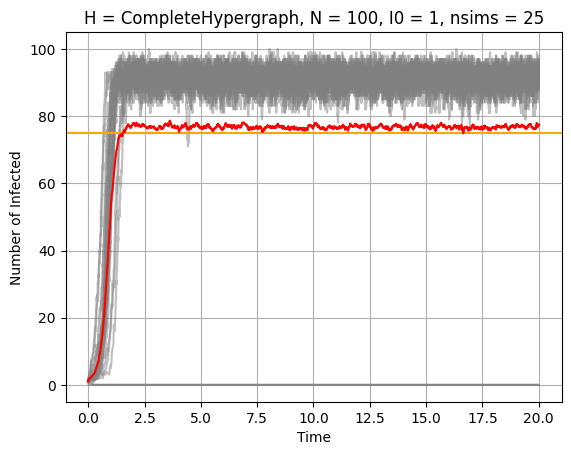

In [11]:
## --- Run Gillespie ---

I0_gillespie = 1 # TODO: go over the range when necessary
initial_infections = list(range(I0_gillespie))

if run_gillespie_simulations: 
    X_sims = []
    for _ in range(nsims):
        X_t = gillespie_sim(
            g, beta1, beta2, mu, initial_infections, time_max)
        X_sims.append(X_t)

    # save the simulation results
    sim_results = {f'sim_{i}': X_sims[i] for i in range(nsims)}
    np.savez_compressed('../results/sim_results_debug.npz', **sim_results)
else: 
    # load simulation results
    sim_results = np.load('../results/sim_results_debug.npz', allow_pickle=True)
    X_sims = [sim_results[f'sim_{i}'] for i in range(nsims)]

# plot X_t curves in gray and average curve in red
fig = plt.figure()
ax  = plt.subplot()

for X_t in X_sims:
    ax.plot(X_t[0], X_t[2], c="gray", alpha=0.5)

avg_curve, times = get_average(X_sims, time_max, nsims, delta_t = 0.01)

plt.axhline(y=75, color='orange', linestyle='-')

plt.plot(times, avg_curve, "red")

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.grid(True)
plt.title(f"H = {g.__class__.__name__}, N = {N}, I0 = {I0_gillespie}, nsims = {nsims}")
plt.savefig("../figures/estimation/complete/gillespie-sims_debug.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Solve KEs and compare

p0 = [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] ...


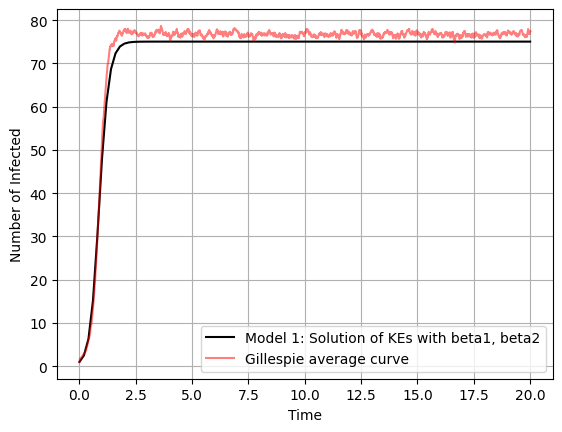

In [12]:
## --- Solve KEs and compare ---
M = N + 1
all_states = list_all_states(g)

# set the initial condition
p0 = np.zeros(M)
p0[I0] = 1.0 # all other states have prob 0 at time 0
print(f"p0 = {p0[:20]} ...")

# time range and times to evaluate solution
nsteps = 101
t_span = (0.0, time_max)
t_eval = np.linspace(t_span[0], t_span[1], nsteps)    

ode_system_complete = list_all_ODEs_complete(g, beta1, beta2, mu)
def f_ode(t, p):
    return ode_system_complete(t, p)
sol = solve_ivp(f_ode, 
                t_span, 
                p0, 
                t_eval=t_eval,
                method="LSODA")
expected_values = calculate_expected_values(sol)

plt.figure()
plt.plot(sol.t, expected_values, color="k", label="Model 1: Solution of KEs with beta1, beta2")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.5)

plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.savefig("../figures/estimation/complete/solution-of-KEs_debug.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

## Calculate the estimates

In [13]:
## --- Calculate the estimates ---
min_Tk_threshold = 1e-6
estimates = calculate_estimates(X_sims, N)

NameError: name 'durations' is not defined

In [14]:
a_k_hat = estimates["a_k_hat"]
b_k_hat = estimates["b_k_hat"]
c_k_hat = estimates["c_k_hat"]

# plot only where T_k was non-zero!
valid_k_idx = estimates["T_k"] > min_Tk_threshold   

# and compare them to theoretical rates
k_values = np.arange(0, N + 1) # number of infected from 0 to N
k_choose_2 = np.array(list(map(lambda k: comb(k, 2, exact=True), k_values)))
a_k = beta1 * k_values * (N - k_values)
b_k = beta2 * k_choose_2 * (N - k_values)
c_k = mu * k_values

fig = plt.figure()
ax = plt.subplot()

# theoretical ak vs. ak hats 
ax.plot(k_values, a_k, label=r'$a_k$', color="red")
ax.scatter(k_values[valid_k_idx], a_k_hat[valid_k_idx],
        label=r'$\widehat{a}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Counts")
plt.legend()
plt.grid(True)    
plt.savefig("../figures/estimation/complete/estimates_ak_debug.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

# theoretical bk vs. bk hats
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, b_k, label=r'$b_k$', color="blue")
ax.scatter(k_values[valid_k_idx], b_k_hat[valid_k_idx],
        label=r'$\widehat{b}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig("../figures/estimation/complete/estimates_bk_debug.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

# theoretical ck vs. ck hats (as a test only)
fig = plt.figure()
ax = plt.subplot()
ax.plot(k_values, c_k, label=r'$c_k$', color="green")
ax.scatter(k_values[valid_k_idx], c_k_hat[valid_k_idx],
        label=r'$\widehat{c}_k$', color="black", alpha=0.9)
plt.xlabel("Number of Infected")
plt.ylabel("Rates and Estimates")
plt.legend()
plt.grid(True)    
plt.savefig("../figures/estimation/complete/estimates_ck_debug.pdf", 
            format='pdf', bbox_inches='tight')    
plt.show()

NameError: name 'estimates' is not defined

## Solve KEs using the estimates 

In [15]:
## --- Solve KEs using the estimates and compare ---
# --- Model 2 ---
ode_system_complete = list_all_ODEs_using_estimates(g, a_k_hat, b_k_hat, mu)

def f_ode(t, p):
    return ode_system_complete(t, p)

sol_hat = solve_ivp(f_ode, 
                    t_span, 
                    p0, 
                    t_eval=t_eval,
                    method="LSODA")

expected_values_hat = calculate_expected_values(sol_hat)
plt.figure()
plt.plot(sol.t, expected_values, color="k", label="Model 1: Solution of KEs with beta1, beta2")
plt.plot(sol.t, expected_values_hat, color="b", label="Model 2: Solution of KEs with ak_hats, bk_hats")
plt.plot(times, avg_curve, 'red', label="Gillespie average curve", alpha=0.5)
plt.xlabel("Time")
plt.ylabel("Number of Infected")
plt.legend()
plt.grid(True)
plt.savefig("../figures/estimation/complete/solutions-comparison_debug.pdf", 
            format='pdf', bbox_inches='tight')
plt.show()

NameError: name 'a_k_hat' is not defined

# DEBUG

In [16]:
len(X_sims)

25

In [17]:
# Single X_t:
#  0     1              2         3           4         5
# [time, time_to_event, infected, event_type, total_pw, total_ho]
# Columns of data: 
# [nsim, time, time_to_event, infected, event_type, total_pw, total_ho]

# double check how we add up durations
X_t = X_sims[2]
X_t.shape

(6, 3730)

In [18]:
times, times_to_event, infected, event_types, total_pws, total_hos = \
        X_t[0], X_t[1], X_t[2], X_t[3], X_t[4], X_t[5]

df = pd.DataFrame({ 
    "time": times, 
    "time_to_event": times_to_event,
    "infected": infected,
    "event_type": event_types,
    "total_pw": total_pws,
    "total_ho": total_hos,
})
df.head()

,time,time_to_event,infected,event_type,total_pw,total_ho
0,0,None,1,None,99,0
1,0.084132,0.084132,2,PW,196,98
2,0.141503,0.057371,3,HO,291,291
3,0.168627,0.027124,4,PW,384,576
4,0.240949,0.072322,5,PW,475,950


In [19]:
# Single X_t contains:
#  0     1              2         3           4         5
# [time, time_to_event, infected, event_type, total_pw, total_ho]
times = X_t[0]
infected_counts = X_t[2]
event_types = X_t[3]
durations = np.diff(times)
[np.round(duration, 6) for duration in durations][:5]

[np.float64(0.084132),
 np.float64(0.057371),
 np.float64(0.027124),
 np.float64(0.072322),
 np.float64(0.002841)]

In [20]:
df.tail()

,time,time_to_event,infected,event_type,total_pw,total_ho
3725,19.980791,0.004149,90,RC,900,40050
3726,19.986823,0.006032,91,PW,819,36855
3727,19.998123,0.0113,92,HO,736,33488
3728,20.002943,0.00482,91,RC,819,36855
3729,20,0.00482,91,None,None,None


In [21]:
[np.round(duration, 6) for duration in durations][-5:]

[np.float64(0.004149),
 np.float64(0.006032),
 np.float64(0.0113),
 np.float64(0.00482),
 np.float64(-0.002943)]

20